### Import data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima 
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

display(HTML('<style>.container{width:100% !important;}</style>'))

dates = pd.date_range(start = '2019-01-01', end = '2021-12-01', freq = 'MS')

np.random.seed(0) 
data = np.random.randn(len(dates)) * 10 + (np.arange(len(dates)) * 3)

df = pd.DataFrame(data, index = dates, columns = ['Sales'])
df.head(3)

,Sales
2019-01-01,17.640523
2019-02-01,7.001572
2019-03-01,15.787380


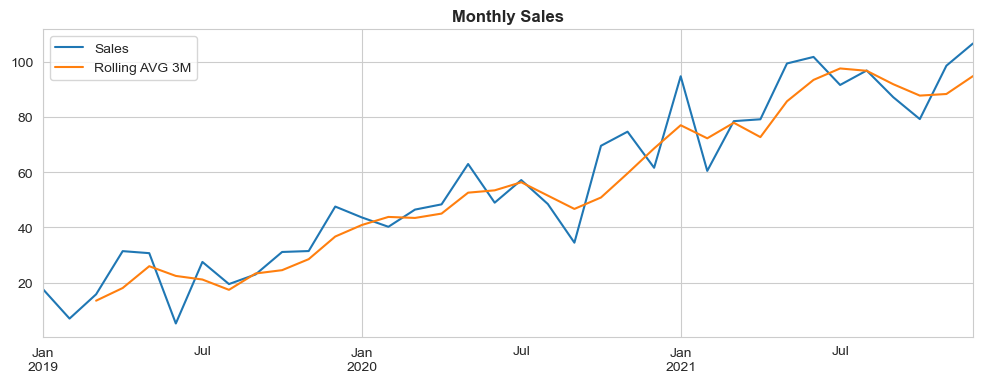

In [2]:
# Assign column name
param = 'Sales'
####################

temp = df.copy()

sns.set_style('whitegrid')

roll_months = 3
new_col = f'Rolling AVG {roll_months}M'
temp[new_col] = temp[param].rolling(window = roll_months).mean()

temp.plot(figsize = (12,4))
plt.title('Monthly Sales', weight = 'bold');

### Seasonal decompose

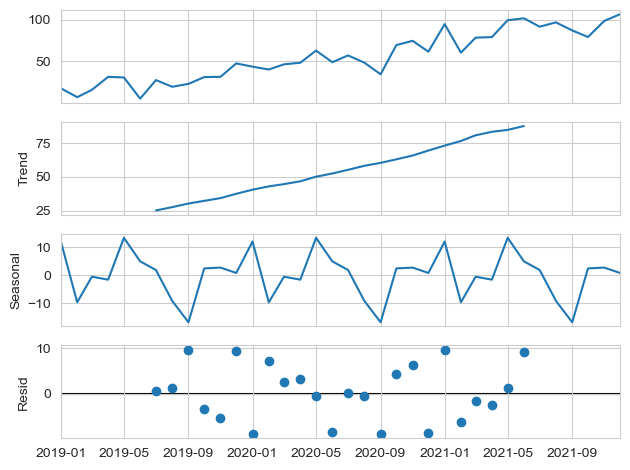

In [3]:
decomposition = sm.tsa.seasonal_decompose(df, model = 'additive')
fig = decomposition.plot();

### Stationarity

In [4]:
# Testing the Stationarity (using Dickey-Fuller model)

"""
Hypothesis testing:
H0: the data isn't stationary
H1: the data is stationary
"""

def adfuller_test(values):
    
    result = adfuller(values)
    labels = ['ADF test statistic', 'p-value', '# of lags used', '# of observations used']
    
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))
    if result[1] <= 0.05:
        print(''), print('low p-value, the series is stationary :)')
    else:
        print(''), print('high p-value, the series is NOT stationary :(')
    
adfuller_test(df[param])

ADF test statistic : -0.33032489252097
p-value : 0.921098257839903
# of lags used : 5
# of observations used : 30

high p-value, the series is NOT stationary :(


### Fix instationary data (differencing)

ADF test statistic : -3.0119907438889113
p-value : 0.03378968789051199
# of lags used : 8
# of observations used : 24

low p-value, the series is stationary :)


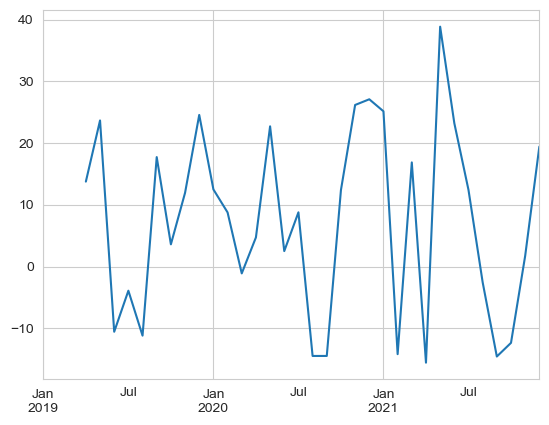

In [5]:
# Differencing
shift = 3
##############

df['differencing'] = df[param] - df[param].shift(shift)

adfuller_test(df['differencing'].dropna())

df['differencing'].plot();

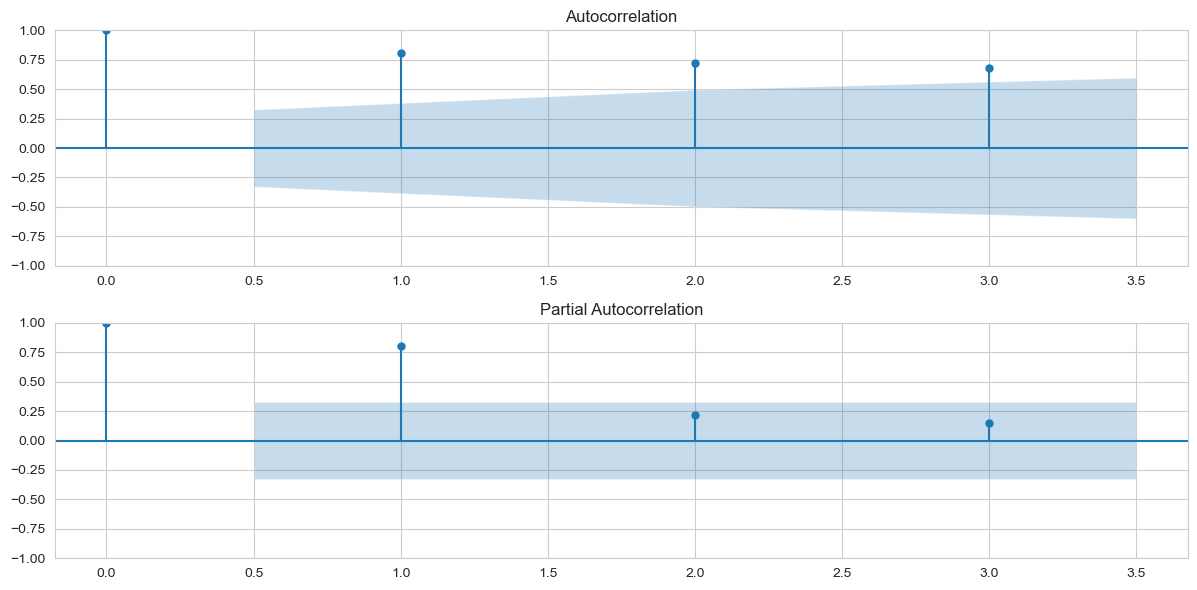

In [6]:
# P = AR model lags (partial auto-correlation) / d = differencing / q = MA lags (auto-correlation)

fig, ax = plt.subplots(2, figsize = (12, 6))
ax[0] = plot_acf(df[param],  ax = ax[0], lags = shift)
ax[1] = plot_pacf(df[param], ax = ax[1], lags = shift)
plt.tight_layout()

In [7]:
# Fit Auto-ARIMA function

stepwise_fit = auto_arima(df[param], 
                          start_p = 1, max_p = 5, start_q = 1, max_q = 5, 
                          m = 12,                    # frequency of series (12 for monthly)
                          seasonal = True, 
                          d = 4,                     # order of first-differencing
                          D = 1,                     # The order of the seasonal differencing
                          trace = True, 
                          error_action ='ignore',    
                          suppress_warnings = True,  
                          stepwise = True)           
  
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,4,1)(1,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(0,4,0)(0,1,0)[12]             : AIC=249.357, Time=0.01 sec
 ARIMA(1,4,0)(1,1,0)[12]             : AIC=235.893, Time=0.05 sec
 ARIMA(0,4,1)(0,1,1)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(1,4,0)(0,1,0)[12]             : AIC=233.937, Time=0.02 sec
 ARIMA(1,4,0)(0,1,1)[12]             : AIC=235.895, Time=0.03 sec
 ARIMA(1,4,0)(1,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(2,4,0)(0,1,0)[12]             : AIC=214.989, Time=0.05 sec
 ARIMA(2,4,0)(1,1,0)[12]             : AIC=213.568, Time=0.06 sec
 ARIMA(2,4,0)(2,1,0)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(2,4,0)(1,1,1)[12]             : AIC=215.183, Time=0.23 sec
 ARIMA(2,4,0)(0,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(2,4,0)(2,1,1)[12]             : AIC=215.984, Time=0.50 sec
 ARIMA(3,4,0)(1,1,0)[12]             : AIC=211.570, Time=0.11 sec
 ARIMA(3,4,0)(0,1,0)[12]             : AIC=214.819, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   36
Model:             SARIMAX(4, 4, 1)x(1, 1, [], 12)   Log Likelihood                 -94.800
Date:                             Tue, 02 Apr 2024   AIC                            203.600
Time:                                     09:15:49   BIC                            210.570
Sample:                                 01-01-2019   HQIC                           204.960
                                      - 12-01-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6381      0.272     -6.018      0.000      -2.172      -1.105
ar.L2         -1.7296      0.528     -3.277      0.001      -2.764      -0.695
ar.L3         -1.1250      0.547     -2.055      0.040      -2.198      -0.052
ar.L4         -0.5588      0.301     -1.858      0.063      -1.148       0.031
ma.L1         -0.9892     11.170     -0.089      0.929     -22.881      20.903
ar.S.L12      -0.4291      0.444     -0.966      0.334      -1.299       0.441
sigma2       414.6693   4632.029      0.090      0.929   -8663.941    9493.280
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 1.26
Prob(Q):                              0.65   Prob(JB):                         0.53
Heteroskedasticity (H):               1.15   Skew:                             0.39
Prob(H) (two-sided):                  0.86   Kurtosis:                         2.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### SARIMAX best params

In [8]:
# Split to train & test
train = df.iloc[:len(df)-12] 
test  = df.iloc[len(df)-12:]

# Best params
n1, n2, n3 = stepwise_fit.order[0], stepwise_fit.order[1], stepwise_fit.order[2]
n4, n5, n6, n7 = stepwise_fit.seasonal_order[0], stepwise_fit.seasonal_order[1], stepwise_fit.seasonal_order[2], stepwise_fit.seasonal_order[3]

# Fit a SARIMAX on the training set 
#model = SARIMAX(train[param], order = (n1,n2,n3), seasonal_order = (n4,n5,n6,n7)) 
model = SARIMAX(train[param], order = (4,1,0), seasonal_order = (1,1,0,12)) 
  
result = model.fit() 
result.summary() 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.46662D+00    |proj g|=  9.84731D-01

At iterate    5    f=  1.67636D+00    |proj g|=  1.10626D-01

At iterate   10    f=  1.62607D+00    |proj g|=  2.65931D-02

At iterate   15    f=  1.62220D+00    |proj g|=  3.44621D-02

At iterate   20    f=  1.61445D+00    |proj g|=  3.40306D-02

At iterate   25    f=  1.60778D+00    |proj g|=  3.70265D-02

At iterate   30    f=  1.60364D+00    |proj g|=  2.17782D-02

At iterate   35    f=  1.60186D+00    |proj g|=  1.43225D-02


 This problem is unconstrained.



At iterate   40    f=  1.60118D+00    |proj g|=  6.45443D-03

At iterate   45    f=  1.60072D+00    |proj g|=  2.61327D-02

At iterate   50    f=  1.60045D+00    |proj g|=  7.25841D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   7.258D-03   1.600D+00
  F =   1.6004519325108608     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   24
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 -38.411
Date:                            Tue, 02 Apr 2024   AIC                             88.822
Time:                                    09:15:49   BIC                             91.209
Sample:                                01-01-2019   HQIC                            87.317
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1798      0.970     -1.216      0.224      -3.081       0.721
ar.L2         -1.4887      0.717     -2.077      0.038      -2.894      -0.084
ar.L3         -1.2119      1.257     -0.964      0.335      -3.675       1.251
ar.L4         -0.8492      1.002     -0.847      0.397      -2.814       1.115
ar.S.L12      -0.9834      2.355     -0.417      0.676      -5.600       3.633
sigma2         1.5653    219.354      0.007      0.994    -428.360     431.491
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 0.13
Prob(Q):                              0.75   Prob(JB):                         0.94
Heteroskedasticity (H):               3.39   Skew:                            -0.25
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

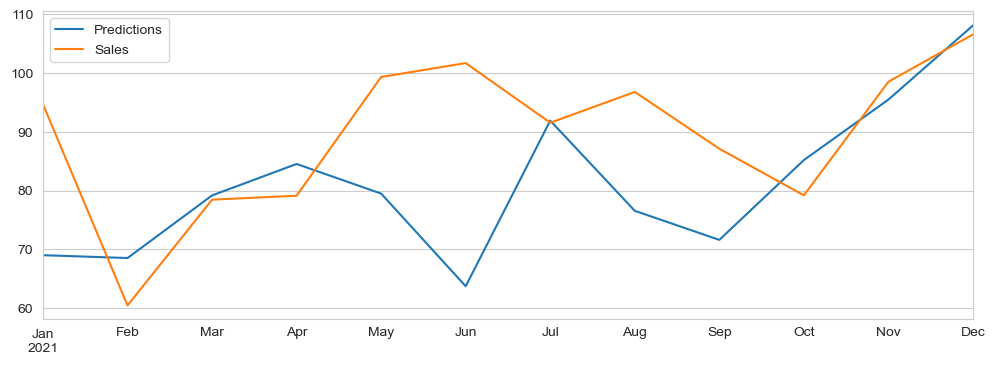

In [9]:
start = len(train) 
end   = len(train) + len(test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, typ = 'levels').rename('Predictions') 
  
plt.rcParams.update({'figure.figsize':(12,4)})

# plot predictions and actual values 
predictions.plot(legend = True) 
test[param].plot(legend = True); 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.55989D+00    |proj g|=  3.89886D-02

At iterate    5    f=  2.55651D+00    |proj g|=  5.67611D-03

At iterate   10    f=  2.55394D+00    |proj g|=  3.68683D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   6.570D-06   2.554D+00
  F =   2.5539149777941907     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


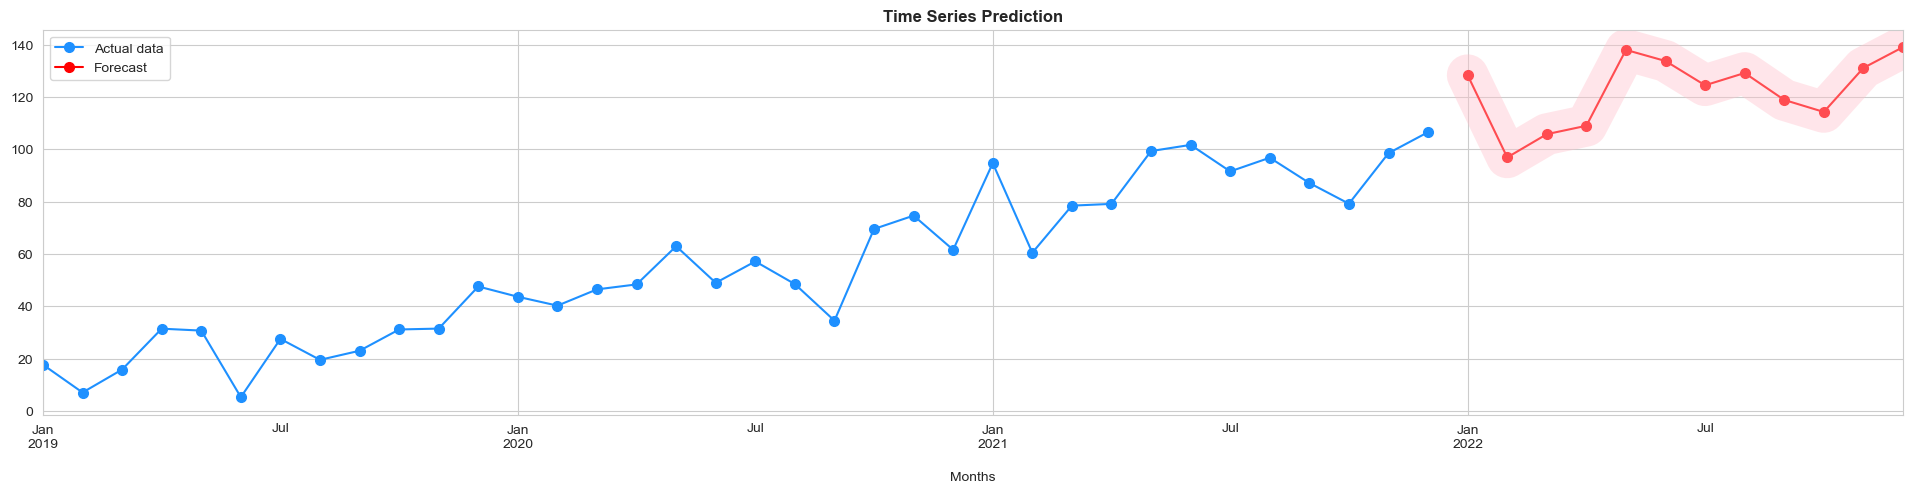

In [15]:
# Train the model on the full dataset 
model = SARIMAX(df[param], order = (4,1,0), seasonal_order = (0,1,0,12)) 

result = model.fit() 
  
# Forecast
forecast = result.predict(start = len(df), end = (len(df)-1) + 12, typ = 'levels').rename('forecast')    
plt.rcParams.update({'figure.figsize':(24,5)})

# Plot the forecast values 
df[param].plot(color = 'dodgerblue', lw = 1.5, legend = True, label = 'Actual data', marker = 'o', ms = 7) 
forecast.plot(color = 'red', lw = 1.5, legend = True, label = 'Forecast', marker = 'o', ms = 7)
forecast.plot(color = 'pink', lw = 30, alpha = .4) 
plt.xlabel('Months', labelpad = 15)
plt.title('Time Series Prediction', weight = 'bold');

In [11]:
final = pd.concat([pd.DataFrame(df[param]), pd.DataFrame(forecast)])
final

,Sales,forecast
2019-01-01,17.640523,NaN
2019-02-01,7.001572,NaN
2019-03-01,15.787380,NaN
2019-04-01,31.408932,NaN
2019-05-01,30.675580,NaN
2019-06-01,5.227221,NaN
2019-07-01,27.500884,NaN
2019-08-01,19.486428,NaN
2019-09-01,22.967811,NaN
2019-10-01,31.105985,NaN
